In [ ]:
# load data
import json
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

with open("../results/ImageNet_results_mean.json", "r") as f:
    results_IN = json.load(f)

# Define consistent feature order
feature_order = [
    "ResNet18_ImageNet",
    "ResNet34_ImageNet",
    "ResNet50_ImageNet",
    "ResNet101_ImageNet",
    "ViT_b_16_ImageNet",
    "ViT_l_16_ImageNet",
    "ViT_b_32_ImageNet",
    "ViT_l_32_ImageNet",
    "DINOv2_small",
    "DINOv2_base",
    "DINOv2_large",
    "DINO_RN",
    "SimCLR",
    "ViT_MAE",
    "CLIP",
    "IJEPA",
]

# Constants for normalization
LABEL_SCALING = {
    "hue": 32400,  # 180^2
    "brightness": 65536,  # 256^2
    "saturation": 65536,  # 256^2
}
TRANSFORM_SCALING = {"HueShift": 1, "BrightnessShift": 1, "SaturationShift": 1}

# 1. INFO_DOWN Plots
info_data = {"linear": [], "nonlinear": []}
for run_name, metrics in results_IN.items():
    if "INFO_DOWN_regression_" in run_name:
        feature = next(f for f in feature_order if f in run_name)
        label = next(l for l in ["brightness", "hue", "saturation"] if l in run_name)
        # Compute RMSE by taking the square root after scaling
        scaled_rmse = math.sqrt(metrics["mse"] / LABEL_SCALING[label])

        if "linear" in run_name:
            info_data["linear"].append(
                {"Feature": feature, "Label": label, "MSE": scaled_rmse}
            )
        else:
            info_data["nonlinear"].append(
                {"Feature": feature, "Label": label, "MSE": scaled_rmse}
            )

df_info_nonlinear = pd.DataFrame(info_data["nonlinear"])
df_info_linear = pd.DataFrame(info_data["linear"])

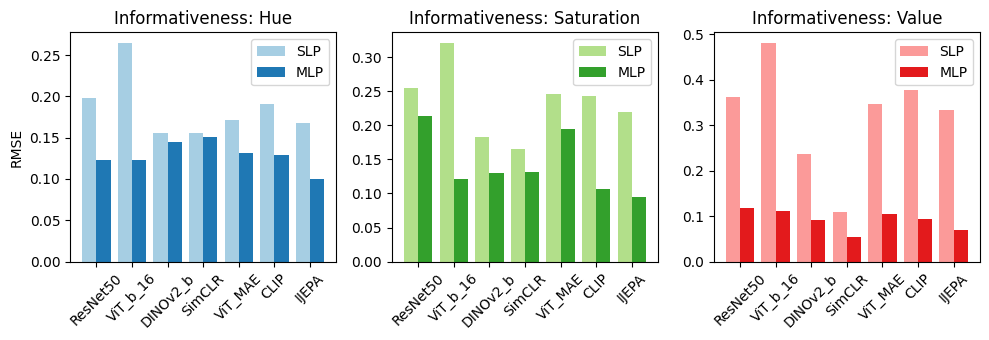

In [ ]:
# ----- INFO_DOWN Combined Plot with custom label order (h, s, v) -----
# Mark each probe type
df_info_linear["Type"] = "SLP"
df_info_nonlinear["Type"] = "MLP"
df_info_combined = pd.concat([df_info_linear, df_info_nonlinear])

# Define only the features (models) to plot
features_to_plot = [
    "ResNet50_ImageNet",
    "ViT_b_16_ImageNet",
    "DINOv2_base",
    "SimCLR",
    "ViT_MAE",
    "CLIP",
    "IJEPA",
]

# Instead of sorting, force the order: hue, saturation, brightness (shown as value)
desired_order = ["hue", "saturation", "brightness"]
# Ensure only labels that exist in the data are kept:
info_labels = [
    lbl for lbl in desired_order if lbl in df_info_combined["Label"].unique()
]

cmap = plt.get_cmap("Paired")
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
if len(info_labels) == 1:
    axes = [axes]  # ensure iterable axis

for i, label in enumerate(info_labels):
    df_label = df_info_combined[df_info_combined["Label"] == label]
    # Pivot so each feature gets both SLP and MLP values
    pivot = df_label.pivot(index="Feature", columns="Type", values="MSE")
    # Filter the pivot table to only the features you want and maintain order
    pivot = pivot.reindex(features_to_plot)
    x = np.arange(len(pivot.index))
    bar_width = 0.4

    # Remove "_ImageNet" from the feature names for display and apply other modifications
    display_features = [
        feat.replace("_ImageNet", "")
        .replace("small", "s")
        .replace("base", "b")
        .replace("large", "l")
        for feat in pivot.index
    ]

    # Use different colors for each plot:
    color_slp = cmap(i * 2)
    color_mlp = cmap(i * 2 + 1)

    axes[i].bar(
        x - bar_width / 2, pivot["SLP"], width=bar_width, color=color_slp, label="SLP"
    )
    axes[i].bar(
        x + bar_width / 2, pivot["MLP"], width=bar_width, color=color_mlp, label="MLP"
    )
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(display_features, rotation=45)
    # Map brightness to value for display purposes
    label_map = {"brightness": "value", "hue": "hue", "saturation": "saturation"}
    axes[i].set_title(f"Informativeness: {label_map[label].capitalize()}")
    if i == 0:
        axes[i].set_ylabel("RMSE")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from config.features import configs as feature_configs

with open(project_root / "results/LibriSpeech_results_mean.json", "r") as f:
    ls_results = json.load(f)

# Define consistent feature order
ls_feature_order = [
    "AudioMAE",
    "CLAP",
    "HuBERT",
    "Wav2Vec2",
    "UniSpeech",
    "Whisper",
    "XVector",
    "MDuo",
]

# Constants for normalization (placeholders)
ls_LABEL_SCALING = {
    "wps": 1,  # Placeholder value
}
ls_TRANSFORM_SCALING = {
    "PitchShift": 1,
    "TimeStretch": 1,
    "AddWhiteNoise": 1,
}  # Placeholder values

# 1. INFO_DOWN Plots
ls_info_data = {"linear": [], "nonlinear": []}
for run_name, metrics in ls_results.items():
    if "INFO_DOWN_regression_" in run_name:
        feature = next((f for f in ls_feature_order if f in run_name), None)
        label = next((l for l in ["wps"] if l in run_name), None)
        if feature and label:
            scaled_mse = math.sqrt(metrics["mse"] / ls_LABEL_SCALING[label])
            if "linear" in run_name:
                info_data["linear"].append(
                    {"Feature": feature, "Label": label, "MSE": scaled_mse}
                )
            else:
                info_data["nonlinear"].append(
                    {"Feature": feature, "Label": label, "MSE": scaled_mse}
                )

ls_df_info_nonlinear = pd.DataFrame(ls_info_data["nonlinear"])
ls_df_info_linear = pd.DataFrame(ls_info_data["linear"])

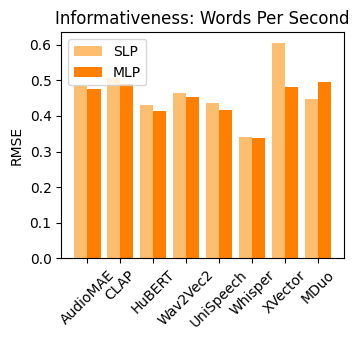

In [ ]:
# Create a combined INFO_DOWN dataframe with a new 'Type' column.
ls_df_info_nonlinear["Type"] = "MLP"
ls_df_info_linear["Type"] = "SLP"
ls_df_info_combined = pd.concat([df_info_nonlinear, df_info_linear])

# Pivot the data so each feature has both SLP and MLP MSE values.
pivot = ls_df_info_combined.pivot(index="Feature", columns="Type", values="MSE")
pivot = pivot.reindex(ls_feature_order)

import numpy as np

# Use the Paired colormap from matplotlib
cmap = plt.get_cmap("Paired")
colors_info = {"SLP": cmap(6), "MLP": cmap(7)}

x = np.arange(len(pivot.index))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(10 * 2.6 / 7.14, 3.5))
ax.bar(
    x - bar_width / 2,
    pivot["SLP"],
    width=bar_width,
    color=colors_info["SLP"],
    label="SLP",
)
ax.bar(
    x + bar_width / 2,
    pivot["MLP"],
    width=bar_width,
    color=colors_info["MLP"],
    label="MLP",
)

ax.set_xticks(x)
ax.set_xticklabels(pivot.index, rotation=45)
ax.set_ylabel("RMSE")
ax.set_title("Informativeness: Words Per Second")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()